In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline
sns.set(rc={'figure.figsize': (12., 6.)})
sns.set_style('whitegrid')

# Getting data

In [2]:
df = pd.read_csv('data/wine.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# Dupes

In [4]:
df.duplicated().value_counts()
# we don't have an id, so we might be inclined not to drop them at first.

False    1359
True      240
dtype: int64

In [5]:
df[df.duplicated()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


# Visualising the data

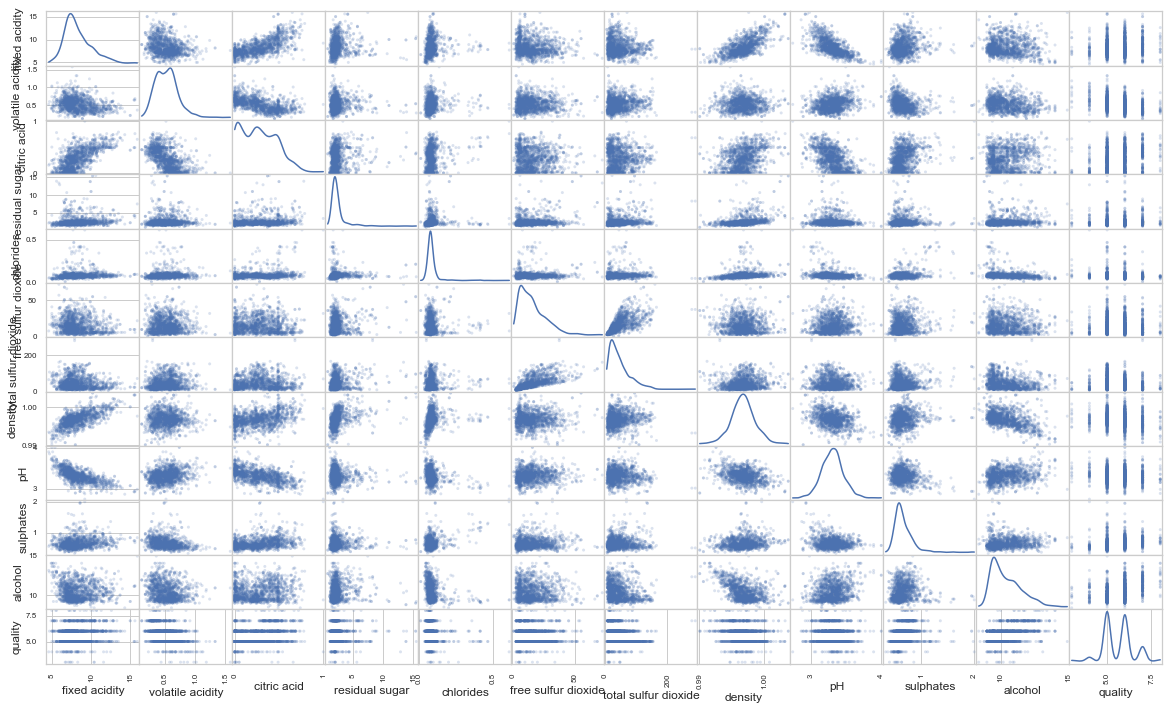

In [6]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(20,12), diagonal='kde');

## Correlation matrix

In [7]:
correlations_matrix = df.corr()

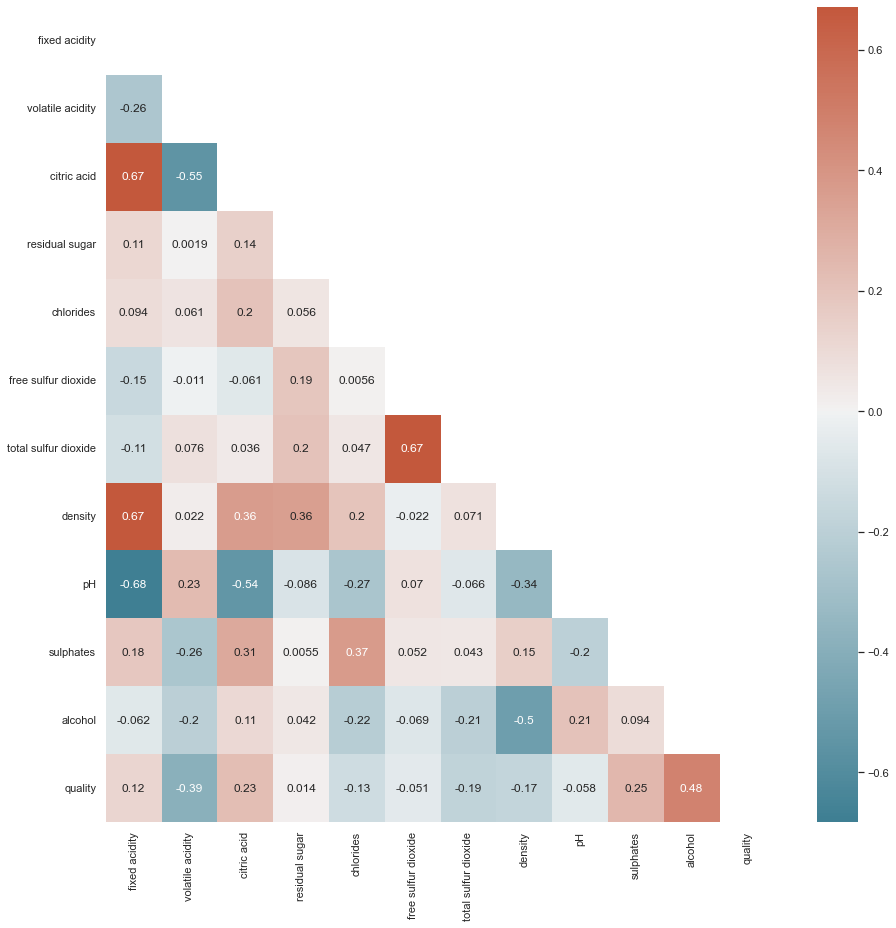

In [8]:
mask=np.zeros_like(correlations_matrix) # this numpy mask eliminates the repeated correlations in the matrix.
mask[np.triu_indices_from(mask)]=True
fig, ax = plt.subplots(figsize=(15,15))
ax=sns.heatmap(correlations_matrix, mask=mask, annot=True, center=0, 
               cmap=sns.diverging_palette(220, 20, as_cmap=True)); #since there are negative correlations, 

In [9]:
df.drop(['volatile acidity', 'chlorides', 'total sulfur dioxide', 'density', 'pH'], axis=1, inplace=True)
# dropping features that correlate negatively with quality (?)

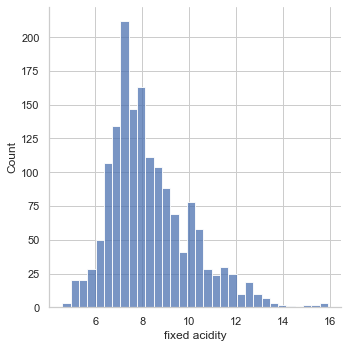

In [10]:
sns.displot(df['fixed acidity']);

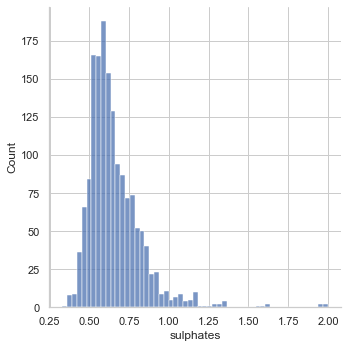

In [11]:
sns.displot(df['sulphates']);

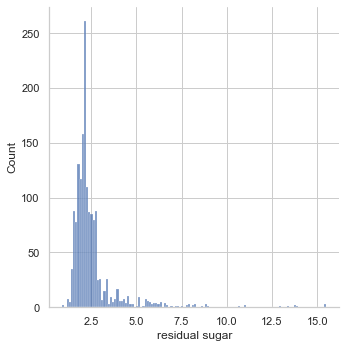

In [12]:
sns.displot(df['residual sugar']);

In [13]:
# rescaling residual sugar column using the BoxCox transform
from scipy import stats
residual_sugar_new, sugar_lambda = stats.boxcox(df['residual sugar'])

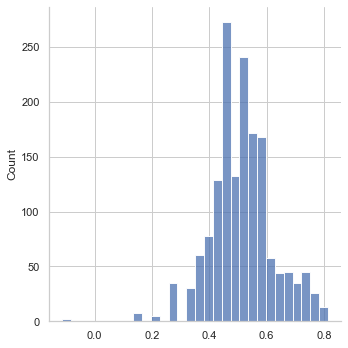

In [14]:
sns.displot(residual_sugar_new, bins=30);

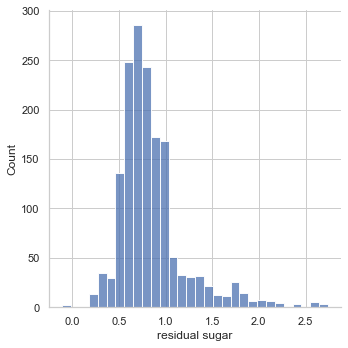

In [15]:
df['residual sugar'] = np.log(df['residual sugar'])
sns.displot(df['residual sugar'], bins=30);
# one way or another, we dealt with the outliers

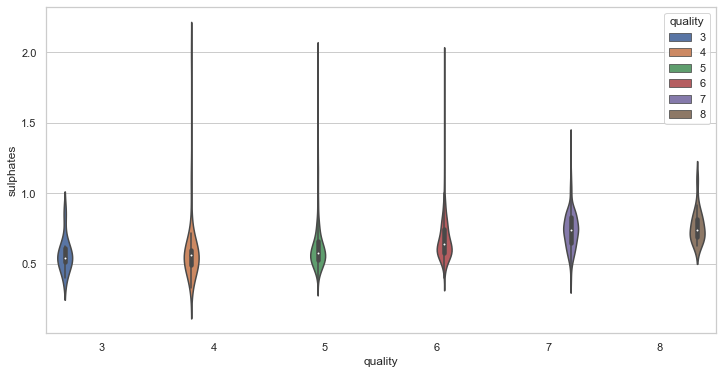

In [16]:
ax = sns.violinplot(x='quality', y='sulphates', hue='quality', data=df, palette='deep');

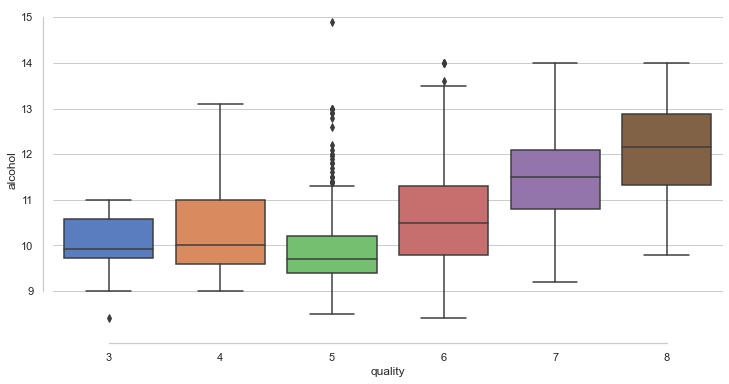

In [17]:
sns.boxplot(x='quality', y='alcohol', palette='muted', data=df)
sns.despine(offset=10, trim=True);

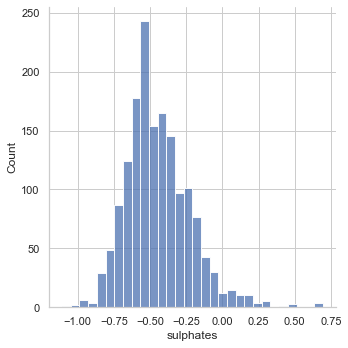

In [18]:
df['sulphates'] = np.log(df['sulphates'])
sns.displot(df['sulphates'], bins=30);

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fixed acidity        1599 non-null   float64
 1   citric acid          1599 non-null   float64
 2   residual sugar       1599 non-null   float64
 3   free sulfur dioxide  1599 non-null   float64
 4   sulphates            1599 non-null   float64
 5   alcohol              1599 non-null   float64
 6   quality              1599 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 87.6 KB


In [20]:
y = df['quality']
X = df.drop(['quality'], axis=1)

In [21]:
# Scaling all numbers
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [22]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42)

In [24]:
KNN = KNeighborsClassifier(n_neighbors = 10)

In [25]:
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [26]:
y_preds = KNN.predict(X_test)

In [27]:
accuracy_score(y_test, y_preds)

0.5583333333333333

In [28]:
c_m = confusion_matrix(y_test, y_preds)
c_m

array([[  0,   0,   1,   0,   0,   0],
       [  0,   0,   8,   9,   0,   0],
       [  0,   0, 146,  47,   2,   0],
       [  1,   0,  86, 103,  10,   0],
       [  0,   0,   8,  34,  19,   0],
       [  0,   0,   0,   2,   4,   0]])

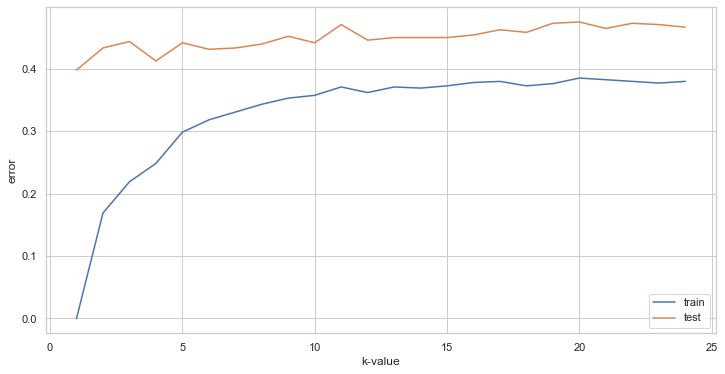

In [29]:
# finding correct k value
error_train = []
error_test = []
for k in range(1, 25):
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    y_pred1 = KNN.predict(X_train)
    error_train.append(np.mean(y_train != y_pred1)) # or append accuracy score
    y_pred2 = KNN.predict(X_test)
    error_test.append(np.mean(y_test != y_pred2))
plt.plot(range(1, 25), error_train, label='train')
plt.plot(range(1, 25), error_test, label='test')
plt.xlabel('k-value')
plt.ylabel('error')
plt.legend();

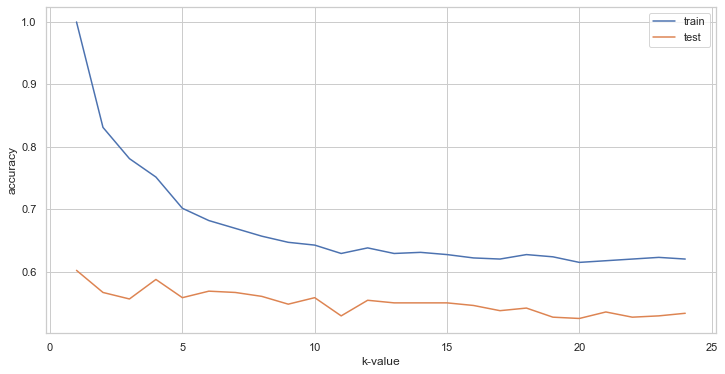

In [30]:
# finding correct k value
acc_train = []
acc_test = []
for k in range(1, 25):
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    y_pred1 = KNN.predict(X_train)
    acc_train.append(accuracy_score(y_train, y_pred1)) # or append accuracy score
    y_pred2 = KNN.predict(X_test)
    acc_test.append(accuracy_score(y_test, y_pred2))
plt.plot(range(1, 25), acc_train, label='train')
plt.plot(range(1, 25), acc_test, label='test')
plt.xlabel('k-value')
plt.ylabel('accuracy')
plt.legend();

In [31]:
df_exercise = df[['residual sugar', 'sulphates', 'quality']]

In [33]:
ex_sample = df_exercise.sample(n=100, random_state=42)

/Applications/anaconda3/envs/bootcamp/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


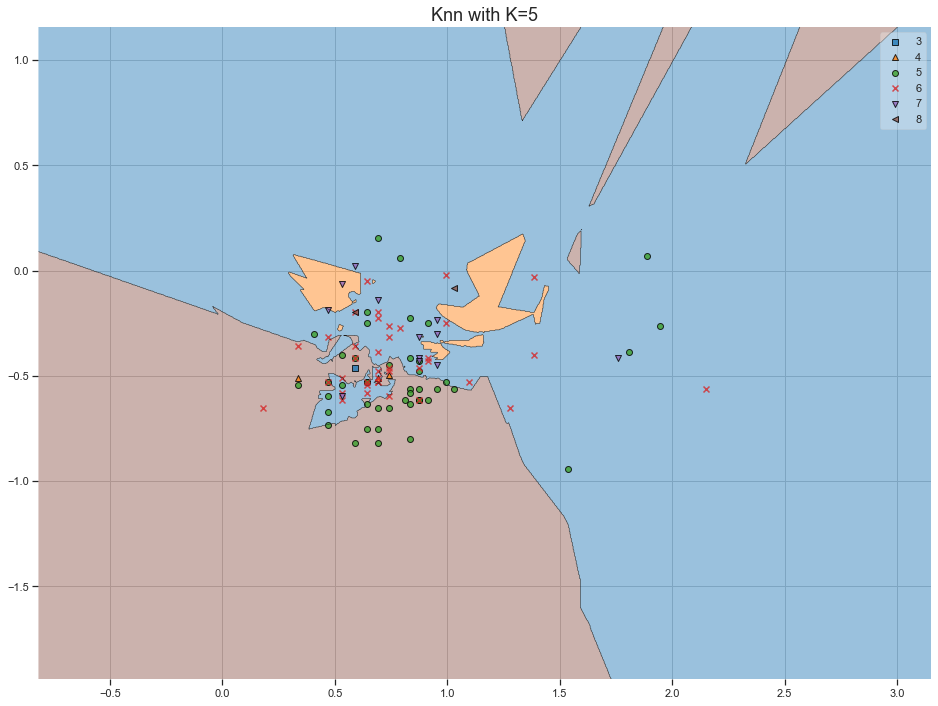

In [34]:
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.plotting import plot_decision_regions

def knn_comparison(data, k):
    x = data.iloc[:, 0:2].values
    y = data.iloc[:, -1].astype(int).values
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x, y)

    plt.figure(figsize=(16,12))
    plot_decision_regions(x, y, clf=knn)
    plt.title("Knn with K="+ str(k), fontsize = 18)
    plt.show()

knn_comparison(ex_sample, 5)

/Applications/anaconda3/envs/bootcamp/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


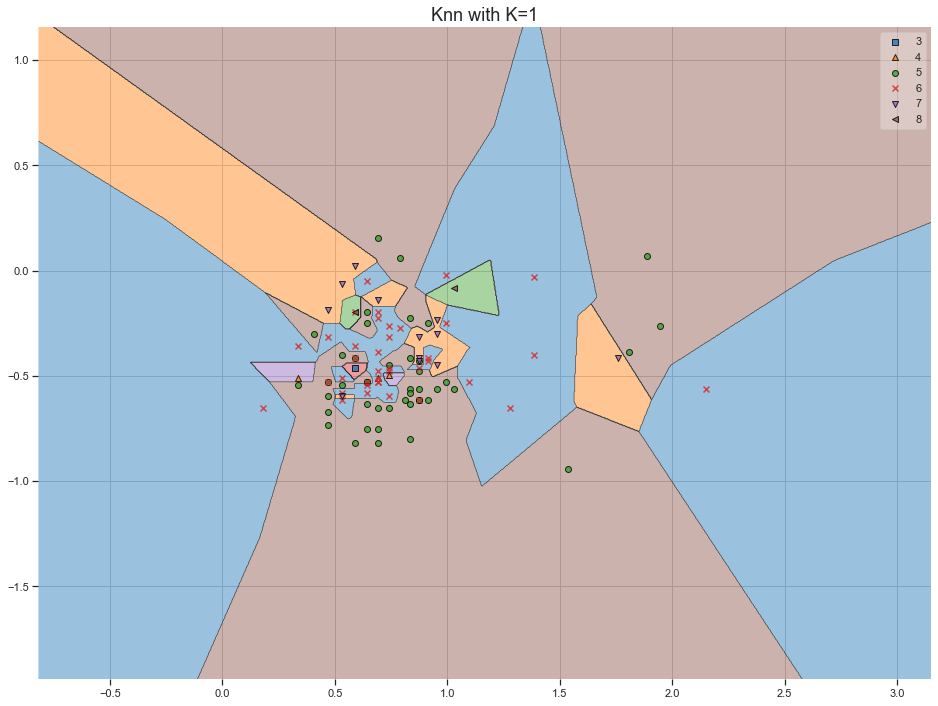

/Applications/anaconda3/envs/bootcamp/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


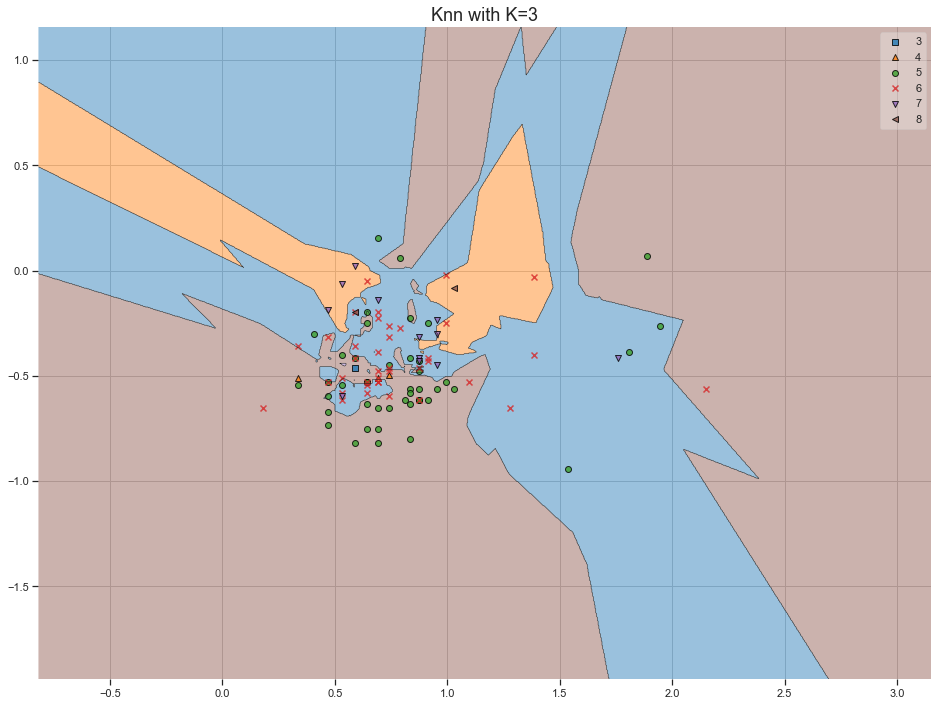

/Applications/anaconda3/envs/bootcamp/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


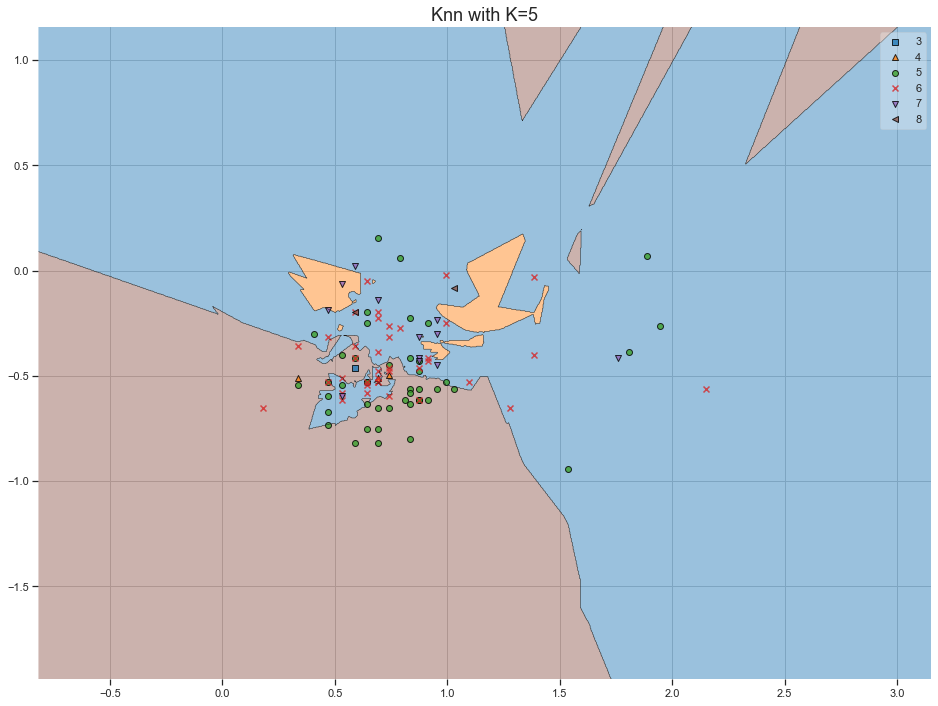

/Applications/anaconda3/envs/bootcamp/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


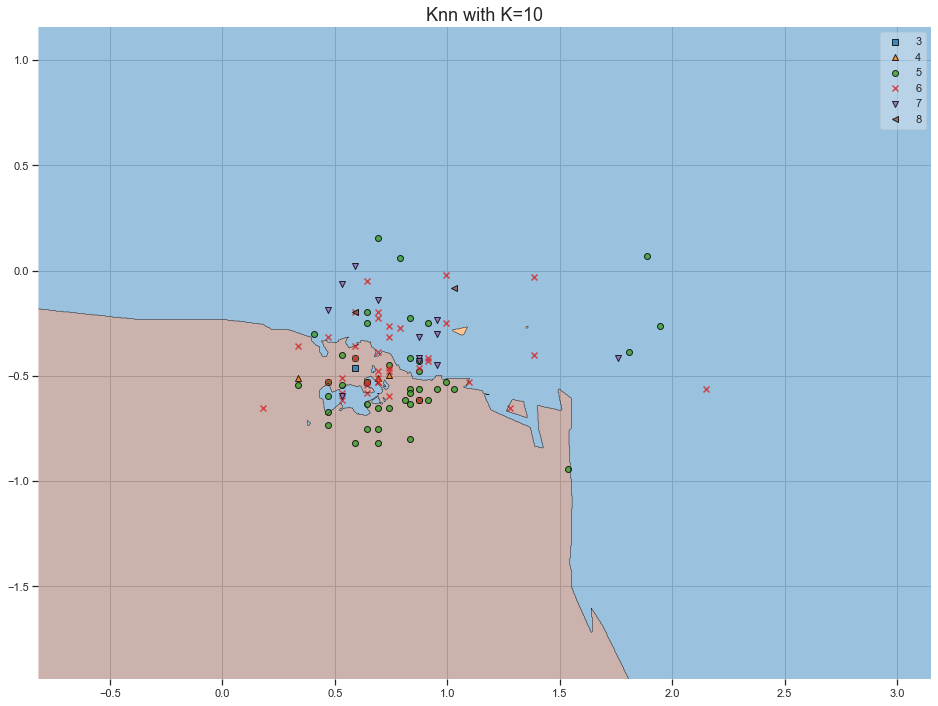

/Applications/anaconda3/envs/bootcamp/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


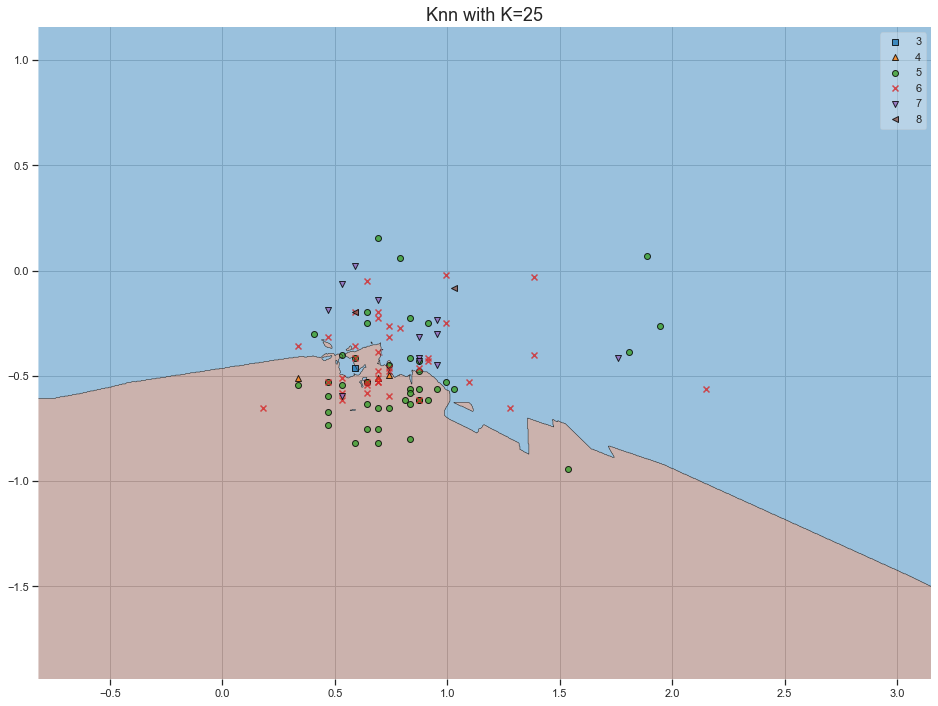

/Applications/anaconda3/envs/bootcamp/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


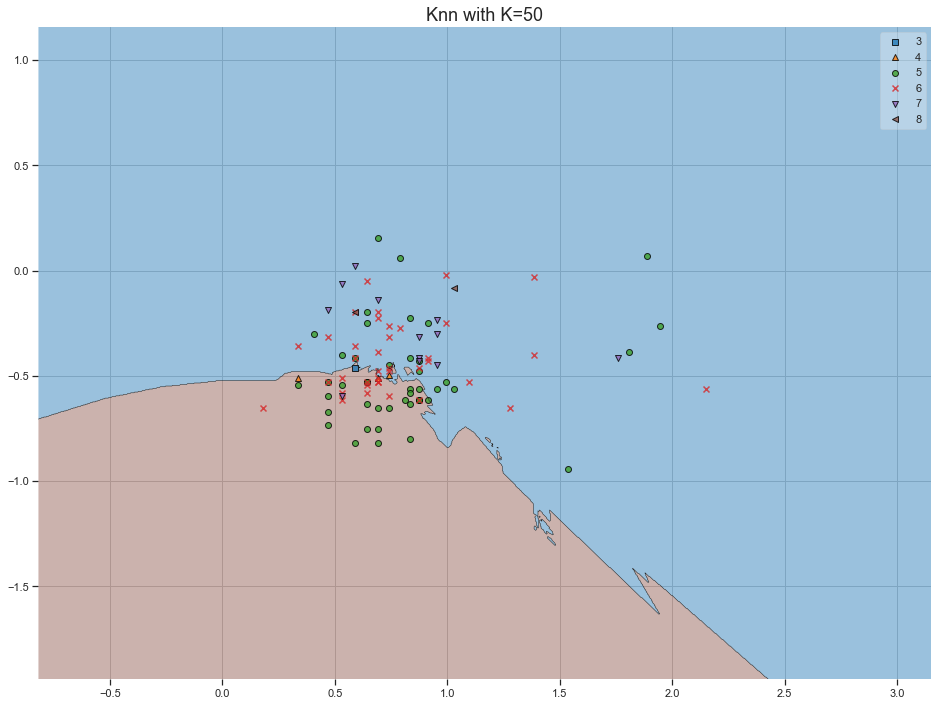

In [35]:
def plot_knn_boundaries():
    ks = [1, 3, 5, 10, 25, 50]
    for k in ks:
        knn_comparison(ex_sample, k)

plot_knn_boundaries()